In [1]:
import numpy as np
import cma

## Define deviated environments

In [2]:
# Create a mutated environment
from gym.envs.classic_control import CartPoleEnv
from types import SimpleNamespace

class MutatedCartPoleEnv(CartPoleEnv):
    def __init__(self, masscart = 1.0, masspole = 0.1, length = 0.5, force_mag = 10.0):
        super().__init__()
        
        self.spec = SimpleNamespace()
        self.spec.id = f"MutatedCartPole-{masscart:.3f}-{masspole:.3f}-{length:.3f}-{force_mag:.3f}"
        
        self.gravity = 9.8
        self.masscart = masscart
        self.masspole = masspole
        self.total_mass = self.masspole + self.masscart
        self.length = length  # actually half the pole's length
        self.polemass_length = self.masspole * self.length
        self.force_mag = force_mag
        self.tau = 0.02  # seconds between state updates
    
    def reset_to(self, state):
        self.state = state
        self.steps_beyond_done = None
        return np.array(self.state, dtype=np.float32)

### Visualize gym helpers

In [62]:
from IPython import display
import matplotlib.pyplot as plt
import time
import imageio
%matplotlib inline


# Define visual experiment
def init_fig(env):
    plt.figure()
    plt.title(f"{env.spec.id} | Episode: 0 | Step: 0 | Reward: 0.0")
    plt.axis('off')
    return plt.imshow(env.render(mode='rgb_array'))

def update_fig(img, env, episode, step, total_reward, done):
    title = plt.title(f"{env.spec.id}\nEp.: {episode} | Step: {step} | Reward: {total_reward} | Done: {done}")
    if done:
        plt.setp(title, color='r')
    else:
        plt.setp(title, color='k')
    img.set_data(env.render(mode='rgb_array'))
    fig = plt.gcf()
    display.display(fig)
    display.clear_output(wait=True)
    
    return np.asarray(fig.canvas.buffer_rgba())

def visual_experiment(env, next_action, max_episode_steps=100, reset_to=None, visualize_in_notebook=True,
                      sleep=0.01, save_gif=None):
    if reset_to is not None:
        obs = env.reset_to(reset_to)
    else:
        obs = env.reset()
    
    if save_gif is not None:
        gif = []
    else:
        gif = None

    # initialize figure in notebook
    if visualize_in_notebook:
        img = init_fig(env)

    total_reward = 0.0
    for step in range(1, max_episode_steps+1):
        action = next_action(obs)
        obs, reward, done, info = env.step(action)
        total_reward += reward

        if visualize_in_notebook:
            fig_data = update_fig(img, env, 1, step, total_reward, done)
            if save_gif is not None:
                gif.append(fig_data)
        else:
            env.render()

        if sleep > 0.0:
            time.sleep(sleep)
    
    if save_gif is not None:
        imageio.mimsave(save_gif, [data for data in gif], fps=10)

## Helper functions

In [4]:
def scale_x(x, bounds):
    """Scale the input numbers in [0, 1] to the range of each variable"""
    return bounds[:, 0] + x * (bounds[:, 1] - bounds[:, 0])

def normalize_x(x_scaled, bounds):
    return (x_scaled - bounds[:, 0]) / (bounds[:, 1] - bounds[:, 0])

## Define RL Agent

In [5]:
# load agent
from stable_baselines3 import PPO

model_ppo = PPO.load("best_model")

In [6]:
from stable_baselines3 import DQN

model_dqn = DQN.load("best_dqn")

#### IMPORTANT: the agent is often non-deterministic

In [7]:
env = MutatedCartPoleEnv()
env.seed(19279)

r1 = []
a1 = []

obs = env.reset()
for _ in range(50):
    r1.append(obs)
    action = model_dqn.predict(obs, deterministic=True)[0] # deterministic=True !!!
    a1.append(action)
    obs, reward, done, info = env.step(action)
env.close()

env = MutatedCartPoleEnv()
env.seed(19279)

r2 = []
a2 = []

obs = env.reset()
for _ in range(50):
    r2.append(obs)
    action = model_dqn.predict(obs, deterministic=True)[0]
    a2.append(action)
    obs, reward, done, info = env.step(action)
env.close()

In [8]:
# the row that the observation becomes different
np.where(np.array(r1) != np.array(r2))

(array([], dtype=int64), array([], dtype=int64))

In [9]:
# the row that the action becomes different
np.where(np.array(a1) != np.array(a2))

(array([], dtype=int64),)

## Define STL robustness estimation functions

In [10]:
# Compute robustness value of the STL formula:
#   G ( pos > -2.4 & pos < 2.4 & angle > -12 degree & angle < 12 degree )
import signal_tl as stl

pos = stl.Predicate('pos')
angle = stl.Predicate('angle')

pos_threshold = 2.4
angle_threshold = 12 * 2 * np.pi / 360

phi = stl.Always(
    (pos > -pos_threshold) & (pos < pos_threshold) &\
    (angle > -angle_threshold) & (angle < angle_threshold)
)

def compute_STL_robustness(records):
    if records.ndim == 2:
        records = np.array([records])
    
    time_index = np.arange(records.shape[1])
    robs = []
    for i in range(len(records)):
        trace = {
            "pos": stl.Signal(records[i, :, 0], time_index),
            "angle": stl.Signal(records[i, :, 2], time_index)
        }
        rob = stl.compute_robustness(phi, trace)
        robs.append(rob.at(0))
    return np.array(robs)

### Estimate robustness by random sampling

In [11]:
def random_sample(env, next_action, max_episode_steps=100, max_episodes=3):
    space = env.observation_space
    # episode_rewards = []
    episode_obs_records = []

    for episode in range(max_episodes):
        # reset env
        obs = env.reset()
        # total_reward = 0.0
        obs_records = [obs]
        out_space = False
        
        for step in range(max_episode_steps):
            action = next_action(obs)
            obs, reward, done, info = env.step(action)
            
            # total_reward += reward
            
            # if the observation is out of the space, clip it and then terminate the episode
            if np.sum(obs < space.low) > 0 or np.sum(obs > space.high) > 0:
                obs = np.clip(obs, space.low, space.high)
                out_space = True
            obs_records.append(obs)
            
            if out_space:
                obs_records = np.append(obs_records, np.full((max_episode_steps-step-1, len(obs)), obs), axis=0)
                break

        # episode_rewards.append(total_reward)
        episode_obs_records.append(obs_records)

    # return np.array(episode_rewards), np.array(episode_obs_records)
    return np.array(episode_obs_records)

In [12]:
# define constraints where input x is in the original domain
def estimate_min_STL_robustness(x):
    masscart = x[0]
    force_mag = x[1]
    env = MutatedCartPoleEnv(masscart=masscart, force_mag=force_mag)
    env.seed(seed)

    # fix the seed so that we can fix the initial states for sampling
    records = random_sample(
        env,
        lambda obs: model.predict(obs, deterministic=True)[0],
        max_episode_steps=max_episode_steps,
        max_episodes=max_episodes
    )

    env.close()

    robs = compute_STL_robustness(records)
    return robs.min()

# wrapped constraints function where input x is in [0, 1] and should be scaled to the original domain
def scaled_estimate_min_STL_robustness(x):
    return estimate_min_STL_robustness(scale_x(x, env_bounds))

In [13]:
def visualize_deviated_env(x, reset_to, save_gif=None):
    masscart = x[0]
    force_mag = x[1]
    env = MutatedCartPoleEnv(masscart=masscart, force_mag=force_mag)
    env.seed(seed)
    
    visual_experiment(env, lambda obs: model.predict(obs, deterministic=True)[0],
                      max_episode_steps=max_episode_steps, reset_to=reset_to, save_gif=save_gif)
    env.close()

### Estimate min robustness by using CMA-ES by varying the initial state

In [14]:
# define the range of the initial set
init_range = np.repeat([[-0.05, 0.05]], 4, axis=0)

array([[-0.05,  0.05],
       [-0.05,  0.05],
       [-0.05,  0.05],
       [-0.05,  0.05]])

In [67]:
def episode_by_init(env, x, next_action, max_episode_steps):
    space = env.observation_space
    obs = env.reset_to(x)
    obs_records = [obs]
    out_space = False
    
    for step in range(max_episode_steps):
        action = next_action(obs)
        obs, reward, done, info = env.step(action)

        # if the observation is out of the space, clip it and then terminate the episode
        if np.sum(obs < space.low) > 0 or np.sum(obs > space.high) > 0:
            obs = np.clip(obs, space.low, space.high)
            out_space = True
        obs_records.append(obs)

        if out_space:
            obs_records = np.append(obs_records, np.full((max_episode_steps-step-1, len(obs)), obs), axis=0)
            break
    
    return np.array(obs_records)


def cma_min_STL_robustness(x):
    masscart = x[0]
    force_mag = x[1]
    env = MutatedCartPoleEnv(masscart=masscart, force_mag=force_mag)
    env.seed(seed)
    
    def objective(y):
        record = episode_by_init(env, y, lambda obs: model.predict(obs, deterministic=True)[0],
                                 max_episode_steps=max_episode_steps)
        return compute_STL_robustness(record)[0]
    
    y0 = np.zeros(4) # TODO: https://lig-kobe-grenoble.imag.fr/wp-content/uploads/2018/03/05.-Session-4-presentation-1-Thao-Dang.pdf
    sigma0 = 0.2
    min_x, es = cma.fmin2(
        lambda y: objective(scale_x(y, init_range)),
        y0,
        sigma0,
        {'bounds': [0.0, 1.0], 'maxfeval': max_episodes, 'ftarget': min_STL_robustness_target, 'verbose': -9, 'seed': seed}
    )
    
    env.close()
    
    return es.result.fbest, scale_x(min_x, init_range)

def scaled_cma_min_STL_robustness(x):
    fbest, _ = cma_min_STL_robustness(scale_x(x, env_bounds))
    return fbest

### Problem configurations

In [68]:
# define variables and their bounds
masscart = [0.1, 2.0]
force_mag = [1.0, 20.0]
env_bounds = np.array([
    masscart,
    force_mag
])

# define objective function
x_original = [
    1.0, # default masscart (not normalized)
    10.0 # default force_mag
]

In [69]:
model = model_dqn
max_episode_steps = 200
max_episodes = 100
seed = 19279

In [70]:
min_STL_robustness_target = 0.0

### Compare two sampling methods

In [18]:
# CMA is better when the agent is deterministic
# for x in np.random.rand(3, 2):
#     est1 = scaled_estimate_min_STL_robustness(x)
#     est2 = scaled_cma_min_STL_robustness(x)
#     if est1 < est2:
#         print(est1, est2, "Random Sample")
#     else:
#         print(est1, est2, "CMA")

### The agent should be safe under the original environment by falsification

In [19]:
fbest, _ = cma_min_STL_robustness(x_original)
fbest > 0.0

True

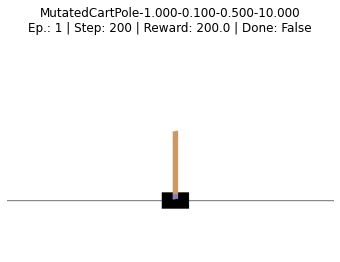

In [50]:
visualize_deviated_env(x_original, [0.0, 0.0, 0.0, 0.0], "gifs/default_env.gif")

![default environment](gifs/default_env.gif)

In [21]:
# l-2 norm distance, the input x is in the original domain
def deviation_dist(x):
    """The variables of the objective function are normalized to [0, 1)"""
    return np.sqrt(np.sum((x - x_original) ** 2))

# wrapped objective function where input x is in [0, 1] and should be scaled to the original domain
def scaled_deviation_dist(x):
    return deviation_dist(scale_x(x, env_bounds))

### CMA for minimizing the STL robustness value given the bounded deviation

In [22]:
# small deviation to have maximize the change in robustness value
# in other words, robustness is: |I' - I| < \Delta => |O' - O| < \epsilon, to falsify the robustness, find an input I''
#   s.t. |I'' - I| < \Delta /\ |O'' - O| > \epsilon

In [23]:
x0 = normalize_x(x_original, env_bounds)
sigma0 = 0.2

_, es1 = cma.fmin2(
    scaled_cma_min_STL_robustness,
    x0,
    sigma0,
    {'bounds': [0.0, 1.0], 'ftarget': min_STL_robustness_target, 'tolstagnation': 0,
     'tolfun': 1e-3, 'tolx': 1e-5, 'timeout': 30 * 60, 'verbose': -9},
)

/home/cj/.pyenv/versions/3.8.10/envs/torch/lib/python3.8/site-packages/gym/envs/classic_control/cartpole.py:150: UserWarning: WARN: You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.
  logger.warn(


In [24]:
es1.result

CMAEvolutionStrategyResult(xbest=array([0.47397796, 0.19880383]), fbest=-0.022444075213713915, evals_best=6, evaluations=7, iterations=1, xfavorite=array([0.51693765, 0.25244596]), stds=array([0.1841405 , 0.23524578]), stop={'ftarget': 0.0})

In [63]:
x = es1.result.xbest
print("Counterexample deviation:", scale_x(x, env_bounds))
print("Deviation distance:", deviation_dist(scale_x(x, env_bounds)))
robustness, x_init = cma_min_STL_robustness(scale_x(x, env_bounds))
print("Counterexample initial state:", x_init)
print("Counterexample robustness value:", robustness)

Counterexample deviation: [1.00055812 4.77727269]
Deviation distance: 5.222727336173933
Counterexample initial state: [-0.04817405 -0.04422767 -0.03384114 -0.02839882]
Counterexample robustness value: -0.022444075213713915


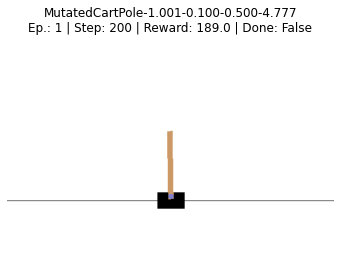

In [64]:
visualize_deviated_env(scale_x(x, env_bounds), x_init, "gifs/counterexample.gif")

![counterexample](gifs/counterexample.gif)

### CMA-ES for minimizing the deviation s.t. the STL is violated (robustness value <= 0)

In [27]:
# set initial variable values to the default value
x0 = normalize_x(x_original, env_bounds)
sigma0 = 0.2

cfun2 = cma.ConstrainedFitnessAL(scaled_deviation_dist, lambda x: [scaled_cma_min_STL_robustness(x)], find_feasible_first=True)
x, es2 = cma.fmin2(
    cfun2,
    x0,
    sigma0,
    {'bounds': [0.0, 1.0], 'tolstagnation': 0, 'tolfun': 1e-3, 'tolx': 1e-5, 'timeout': 30 * 60, 'verbose': -9},
    callback=cfun2.update
)

In [28]:
es2.result

CMAEvolutionStrategyResult(xbest=array([0.99225732, 0.21851902]), fbest=-6.367779313460546, evals_best=41, evaluations=343, iterations=57, xfavorite=array([0.47551893, 0.47413907]), stds=array([8.97119722e-06, 3.14863343e-06]), stop={'tolx': 1e-05})

In [29]:
x = es2.result.xbest
print("Counterexample deviation:", scale_x(x, env_bounds))
print("Deviation distance:", deviation_dist(scale_x(x, env_bounds)))
robustness, x_init = cma_min_STL_robustness(scale_x(x, env_bounds))
print("Counterexample initial state:", x_init)
print("Counterexample robustness value:", robustness)

Counterexample deviation: [1.98528891 5.15186143]
Deviation distance: 4.9472458865418725
Counterexample initial state: [-0.03320979 -0.02281505 -0.04102299 -0.03400642]
Counterexample robustness value: -2.4000001907348634


In [30]:
x = es2.result.xfavorite
print("Counterexample deviation:", scale_x(x, env_bounds))
print("Deviation distance:", deviation_dist(scale_x(x, env_bounds)))
robustness, x_init = cma_min_STL_robustness(scale_x(x, env_bounds))
print("Counterexample initial state:", x_init)
print("Counterexample robustness value:", robustness)

Counterexample deviation: [ 1.00348597 10.00864234]
Deviation distance: 0.00931890862640971
Counterexample initial state: [-0.04937883 -0.04949166 -0.04964778 -0.0497276 ]
Counterexample robustness value: 0.07820028973932716


In [31]:
# plt.rc('font', size=14) 

# es2.plot()

# fig = plt.gcf()
# fig.set_figwidth(18)
# fig.set_figheight(18)

In [32]:
cfun2.best_feas.info

{'x': array([0.99959955, 0.45036773]),
 'f': 1.0930414187371864,
 'g': [-0.04200581298951653],
 'f_al': 0.850919529854195,
 'g_al': [-0.24212188888299152],
 'count': 56}

In [65]:
x = cfun2.best_feas.info['x']
print("Counterexample deviation:", scale_x(x, env_bounds))
print("Deviation distance:", deviation_dist(scale_x(x, env_bounds)))
robustness, x_init = cma_min_STL_robustness(scale_x(x, env_bounds))
print("Counterexample initial state:", x_init)
print("Counterexample robustness value:", robustness)

Counterexample deviation: [1.99923914 9.55698681]
Deviation distance: 1.0930414187371864
Counterexample initial state: [-0.04971445 -0.04464305 -0.04907228 -0.04985199]
Counterexample robustness value: -0.04200581298951653


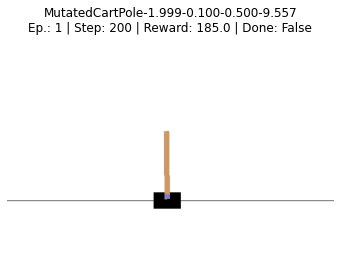

In [66]:
visualize_deviated_env(scale_x(x, env_bounds), x_init, "gifs/min_dev_counterexample.gif")

![min deviation counterexample](gifs/min_dev_counterexample.gif)

In [35]:
# c = es.countiter
# x = cfun.find_feasible(es)
# print("find_feasible took {} iterations".format(es.countiter - c))
# print("Solution:", scale_x(x, env_bounds))
# print("Worst-case robustness value:", scaled_cma_min_STL_robustness(x))  # show constraint violation values

### CMA for finding the maximum deviation s.t. the agent is safe

In [36]:
x0 = normalize_x(x_original, env_bounds)
sigma0 = 0.2

cfun3 = cma.ConstrainedFitnessAL(
    lambda x: -scaled_deviation_dist(x), # maximize distance
    lambda x: [-scaled_cma_min_STL_robustness(x)], # robustness >= 0
#     find_feasible_first=True # assume the initial is already feasible
)
x, es3 = cma.fmin2(
    cfun3,
    x0,
    sigma0,
    {'bounds': [0.0, 1.0], 'tolstagnation': 0, 'tolfun': 1e-3, 'tolx': 1e-5, 'timeout': 30 * 60, 'verbose': -9},
    callback=cfun3.update
)

In [37]:
es3.result

CMAEvolutionStrategyResult(xbest=array([0.00494671, 0.01089495]), fbest=-10.079669869448066, evals_best=131, evaluations=421, iterations=70, xfavorite=array([1.45521828e-02, 5.44925007e-05]), stds=array([7.40023404e-05, 9.02134802e-05]), stop={'timeout': 1800})

In [38]:
# the original x-value may be meaningless
x = es3.result.xbest
print("Counterexample deviation:", scale_x(x, env_bounds))
print("Deviation distance:", deviation_dist(scale_x(x, env_bounds)))
robustness, x_init = cma_min_STL_robustness(scale_x(x, env_bounds))
print("Counterexample initial state:", x_init)
print("Counterexample robustness value:", robustness)

Counterexample deviation: [0.10939875 1.20700408]
Deviation distance: 8.837983242188818
Counterexample initial state: [-0.04929661 -0.04958266 -0.04761136 -0.02339641]
Counterexample robustness value: 0.08723957998867485


In [39]:
x = es3.result.xfavorite
print("Counterexample deviation:", scale_x(x, env_bounds))
print("Deviation distance:", deviation_dist(scale_x(x, env_bounds)))
robustness, x_init = cma_min_STL_robustness(scale_x(x, env_bounds))
print("Counterexample initial state:", x_init)
print("Counterexample robustness value:", robustness)

Counterexample deviation: [0.12764915 1.00103536]
Deviation distance: 9.041148192942373
Counterexample initial state: [-0.04999778 -0.04984857 -0.04216822 -0.03218022]
Counterexample robustness value: 0.0702898593079612


In [57]:
x = cfun3.best_feas.info['x']
print("Counterexample deviation:", scale_x(x, env_bounds))
print("Deviation distance:", deviation_dist(scale_x(x, env_bounds)))
robustness, x_init = cma_min_STL_robustness(scale_x(x, env_bounds))
print("Counterexample initial state:", x_init)
print("Counterexample robustness value:", robustness)

Counterexample deviation: [0.10594628 1.000026  ]
Deviation distance: 9.044272445679361
Counterexample initial state: [-0.04984099 -0.04880254 -0.0499286  -0.03619801]
Counterexample robustness value: 0.06059000803347084


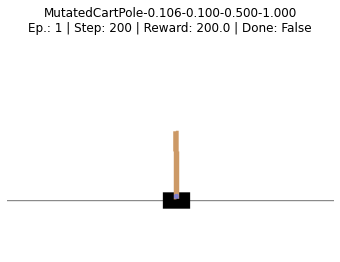

In [58]:
visualize_deviated_env(scale_x(x, env_bounds), x_init, "gifs/max_safe_deviation.gif")

![max safe deviation](gifs/max_safe_deviation.gif)

### Plot the shape of the optimization space using grid

In [143]:
n_mass, n_force = (50, 50)

In [144]:
masses = np.linspace(masscart[0], masscart[1], n_mass)
forces = np.linspace(force_mag[0], force_mag[1], n_force)
masses, forces = np.meshgrid(masses, forces, indexing='ij')

In [145]:
min_STL_robustness_target = -np.inf
grid_data = np.zeros((n_mass, n_force))

for i in range(n_mass):
    for j in range(n_force):
        # treat xv[i,j], yv[i,j]
        m, f = masses[i, j], forces[i, j]
        robustness, _ = cma_min_STL_robustness([m, f])
        grid_data[i, j] = robustness

/home/cj/.pyenv/versions/3.8.10/envs/torch/lib/python3.8/site-packages/gym/envs/classic_control/cartpole.py:150: UserWarning: WARN: You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.
  logger.warn(


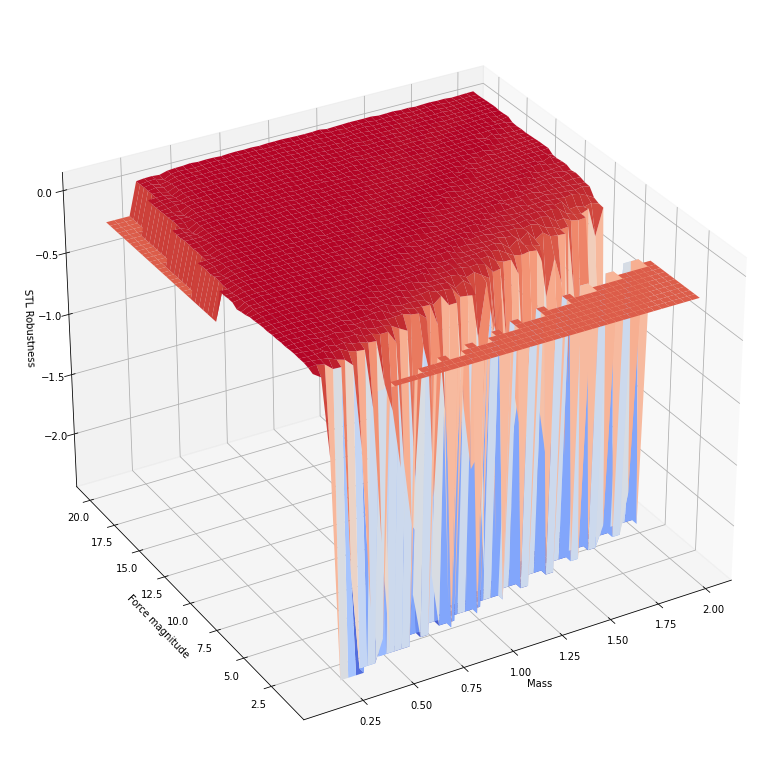

In [149]:
from matplotlib import cm

fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize=(14, 14))
ax.plot_surface(masses, forces, grid_data, cmap=cm.coolwarm)
ax.set_xlabel('Mass')
ax.set_ylabel('Force magnitude')
ax.set_zlabel('STL Robustness')

ax.view_init(30, -120)
plt.savefig('gifs/robustness-landscape.png')
plt.show()